# Einführung in Transfer Learning eines CNN mit Hilfe von pytorch
Original-Idee: https://towardsdatascience.com/a-practical-example-in-transfer-learning-with-pytorch-846bb835f2db  
Wir trainieren ein bestehendes squeezenet-Netzwerk mit Transfer Learning so um, dass damit eine einfache Gestenerkennung in live-Bildern der Webcam möglich wird. Anstatt der Erkennung der ursprünglichen 1000 Objektkategorien (Kategorien des ImageNet) soll das umtrainierte Netz zwischen "ThumbsUp" und "ThumbsDown" unterscheiden. 
<img src="https://gitlab.com/fhgr/DeepLearning/-/raw/main/_ThumbsUpDown_.png" alt="Example images of gesture classification" />

Mehr zum Transferlernen erfahren Sie unter cs231n-Notizen <https://cs231n.github.io/transfer-learning/>. Mehr zum Thema Transferlernen mit PyTorch erfahren Sie unter [Finetuning torchvision models](https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html).

## <a name="Voraussetzungen"></a>Voraussetzungen
Führen Sie die folgenden Befehle über die Befehlszeile aus:  
Eventuell verwenden Sie conda oder pip3, dann ersetzen Sie pip durch den entsprechenden Befehl.  
Alternativ finden Sie die Befehle auch auf der [PyTorch-Webseite](https://pytorch.org/).
<pre>pip install --upgrade torch
pip install --upgrade torchvision</pre>

In [ ]:
%matplotlib inline

In [1]:
#%% imports
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
import glob

PyTorch Version:  1.7.1+cpu
Torchvision Version:  0.2.2


## Inputs
Hier sind alle Parameter, die für die Ausführung ggf. angepasst werden müssen. Wir verwenden den Datensatz MyThumbsGestureData.zip, der [hier](https://gitlab.com/fhgr/bild3/-/raw/master/MyThumbsGestureData.zip) heruntergeladen werden kann. Dieser Datensatz enthält drei Klassen, ThumbsUp, ThumbsDown und eine Klasse ohne Thumbs. Er ist so strukturiert, dass wir den PyTorch-Datenlader direkt zum Einlesen verwenden können. Laden Sie die Daten herunter und legen Sie die Eingabe data_dir auf das Stammverzeichnis des Datasets fest. Die Eingabe model_name ist der Name des gewünschten Modells und muss aus dieser Liste ausgewählt werden:
<pre>Resnet, Alexnet, Vgg, Squeezenet, Densenet, Inception</pre>

Die anderen Eingaben sind wie folgt: num_classes ist die Anzahl der Klassen im Datensatz, batch_size ist die für das Training verwendete Batchgröße und kann entsprechend der Leistungsfähigkeit Ihres Computers angepasst werden (typ. 4 oder 8), num_epochs ist die Anzahl der Trainingsepochen, die wir ausführen möchten, und feature_extract ist ein boolescher Wert, der definiert, ob wir eine Feinabstimmung oder Feature-Extraktion durchführen. Falls feature_extract = False ist, wird das gesamte Netz (Modell) verfeinert und alle Modellparameter werden aktualisiert. Wenn feature_extract = True ist, wird nur der letzte Layer aktualisiert, die anderen bleiben unverändert.

In [2]:
#%% Inputs

# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
data_dir = r"C:\python\WPy64-3850\notebooks\_notebooks\DeepLearning\myGesturesData"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "squeezenet"
# any of [resnet, alexnet, vgg, squeezenet, densenet, inception]

# Number of classes in the dataset
files = glob.glob(os.path.join(data_dir,'train','*'))
num_classes = len(files)
print(f'Number of classes found to train: {num_classes}')

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for
num_epochs = 15

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True


Number of classes found to train: 3


Achtung: Falls hier die Anzahl gefundener Klassen Null ist, dann müssen Sie den Pfad (data_dir) anpassen.

## Helper functions

In [3]:
#%% function train_model
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        time_elapsed = time.time() - since
        print('Elapsed time: {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history



In [4]:
#%% function set_parameter_requires_grad
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            


In [5]:
#%% function initialize_model
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)




SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

### <a name="Augmentation"></a>Data Augmentation und Data Normalization
**Data Augmentation**: Um den Datensatz künstlich zu vergrössern, verwenden wir das Prinzip des **Data Augmentation**, d.h. durch geeignete Bildmodifikationen wie z.B. Spiegelung, Vergrössern, Teil-Ausschnitt, etc. werden scheinbar mehr Trainingsdaten zur Verfügung gestellt. Dies geschieht beim Einlesen automatisch durch Verwendung eines *data transformer*.

**Data Normalization**: Beachten Sie, dass die Bilddaten vor dem Trainieren von Netzwerken normalisiert werden, d.h. sämtliche Bilder werden auf bestimmte Mittelwerte $\mu_\text{net}$ und Varianzen $var_\text{net}$ normiert. 

$$\mu = \text{mean}(img), v = \text{var}(img)$$
$$img_\text{new}= \frac{img-\mu}{v}\cdot var_\text{net} + \mu_\text{net}$$

Ausserdem erwartet das vortrainierte Netz Bilddaten einer bestimmten Grösse (In unserem Beispiel: 224 x 224 pixels).
Die Normalisierungswerte für die einzelnen vortrainierten Netzwerke finden Sie [hier](https://pytorch.org/docs/master/torchvision/models.html).

Schliesslich soll erkannt werden, welches Hardware-Device zum Training zur Verfügung steht. PyTorch erkennt dies automatisch.

Zum Laden, Augmentieren und Normieren der Bilddaten verwenden wir die Pakete *Torchvision* und *Torch.utils.data*.

In [6]:
#%% Data input and augmentation
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using hardware device: ", device)

Initializing Datasets and Dataloaders...


## Optimierer erstellen
Nachdem die Netz-Architektur (Modellstruktur) nun korrekt ist, besteht der letzte Schritt für die Feinabstimmung und Merkmalsextraktion darin, einen Optimierer zu erstellen, der nur die gewünschten Parameter aktualisiert. 
Falls feature_extract=True: Denken Sie daran, dass wir nach dem Laden des vortrainierten Modells, aber vor dem Umtrainieren alle .requires_grad-Attribute des Modells manuell auf False setzen.  
Die Parameter des neu erstellten Layers haben standardmäßig .requires_grad=True. 

Alle Parameter, bei denen .requires_grad=True gesetzt ist, werdem während des Trainings optimiert, d.h. verändert. Wir erstellen eine Liste solcher Parameter und geben diese Liste in den SGD-Algorithmuskonstruktor ein. SGD steht für Stochastic gradient descent, d.h. der Algorithmus optimiert, indem er in die Richtung grosser Änderungen läuft. Netzwerk-Parameter, d.h. Gewichte, die keinen Einfluss auf das Ergebnis haben, liefern einen Gradienten von Null.

Wir geben die Liste der zu änernden Parameter aus. Bei der Feinabstimmung des gesamten Netzes sollte diese Liste lang sein und alle Modellparameter enthalten. Beim Extrahieren von Features, d.h. falls nur der letzte Layer umtrainiert wird, sollte diese Liste jedoch kurz sein. 

In [7]:
#%% Create the Optimizer
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)


Params to learn:
	 classifier.1.weight
	 classifier.1.bias


## Train the model

In [8]:
#%% Run Training and Validation step
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))



Epoch 0/14
----------
train Loss: 0.6277 Acc: 0.7238
val Loss: 0.2824 Acc: 0.9172

Epoch 1/14
----------
train Loss: 0.3621 Acc: 0.8627
val Loss: 0.2591 Acc: 0.9363

Epoch 2/14
----------
train Loss: 0.3663 Acc: 0.8565
val Loss: 0.2220 Acc: 0.9427

Epoch 3/14
----------
train Loss: 0.3226 Acc: 0.8796
val Loss: 0.1939 Acc: 0.9490

Epoch 4/14
----------
train Loss: 0.3126 Acc: 0.8735
val Loss: 0.1601 Acc: 0.9363

Epoch 5/14
----------
train Loss: 0.3297 Acc: 0.8735
val Loss: 0.1758 Acc: 0.9554

Epoch 6/14
----------
train Loss: 0.3012 Acc: 0.8827
val Loss: 0.1513 Acc: 0.9490

Epoch 7/14
----------
train Loss: 0.2692 Acc: 0.8951
val Loss: 0.1296 Acc: 0.9554

Epoch 8/14
----------
train Loss: 0.2557 Acc: 0.8981
val Loss: 0.1430 Acc: 0.9490

Epoch 9/14
----------
train Loss: 0.2938 Acc: 0.8827
val Loss: 0.0827 Acc: 0.9745

Epoch 10/14
----------
train Loss: 0.2655 Acc: 0.8904
val Loss: 0.1031 Acc: 0.9618

Epoch 11/14
----------
train Loss: 0.2521 Acc: 0.9074
val Loss: 0.1224 Acc: 0.9554

Ep

### Abspeichern des Ergebnisses
Falls gewünscht, kann das eingelernte Modell abgespeichert werden. Das Modell kann später oder in einer anderen Umgebung wieder geladen und dann zur Erkennung von Objekten z.B. in live-Bildern der Webcam verwendet werden.

Um das Modell abzuspeichern, setzen Sie "saveModel = True;" und wählen Sie einen Dateinamen (und allenfalls einen Pfad):

In [9]:
saveModel = False;
if(saveModel):
    torch.save(model_ft, 'trained_squeezenet_model.pytorch')

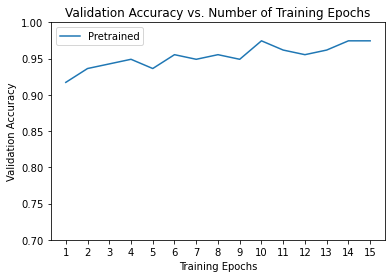

In [13]:
# Plot the training curves of validation accuracy vs. number
#  of training epochs for the transfer learning method and
#  the model trained from scratch
ohist = []

ft_hist = [h.cpu().numpy() for h in hist]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ft_hist,label="Pretrained")
plt.ylim((0.7,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

In [11]:
# to run the model on live images, see python script:
# ApplyMyGestureModel.py